Epoch 10, loss = 0.186446
Epoch 20, loss = 0.106827
Epoch 30, loss = 0.0759946
Epoch 40, loss = 0.0600269
Epoch 50, loss = 0.0497369
Epoch 60, loss = 0.0420013
Epoch 70, loss = 0.0369942
Epoch 80, loss = 0.0323288
Epoch 90, loss = 0.0291004
Epoch 100, loss = 0.0264015
Epoch 110, loss = 0.0240614
Epoch 120, loss = 0.021876
Epoch 130, loss = 0.0203343
Epoch 140, loss = 0.0191416
Epoch 150, loss = 0.0182494
Epoch 160, loss = 0.0174594
Epoch 170, loss = 0.0167223
Epoch 180, loss = 0.0160643
Epoch 190, loss = 0.0157069
Epoch 200, loss = 0.0149182
Epoch 210, loss = 0.0142212
Epoch 220, loss = 0.013749
Epoch 230, loss = 0.0131646
Epoch 240, loss = 0.0128279
Epoch 250, loss = 0.0124629
Epoch 260, loss = 0.0120756
Epoch 270, loss = 0.0118044
Epoch 280, loss = 0.0116704
Epoch 290, loss = 0.0115527
Epoch 300, loss = 0.0111906
Epoch 310, loss = 0.0110614
Epoch 320, loss = 0.0108115
Epoch 330, loss = 0.0105954
Epoch 340, loss = 0.0104417
Epoch 350, loss = 0.0102795
Epoch 360, loss = 0.0101956
Epoch

Epoch 2800, loss = 0.00759613
Epoch 2810, loss = 0.00759613
Epoch 2820, loss = 0.00759613
Epoch 2830, loss = 0.00759613
Epoch 2840, loss = 0.00759613
Epoch 2850, loss = 0.00759613
Epoch 2860, loss = 0.00759613
Epoch 2870, loss = 0.00759613
Epoch 2880, loss = 0.00759613
Epoch 2890, loss = 0.00759613
Epoch 2900, loss = 0.00759613
Epoch 2910, loss = 0.00759613
Epoch 2920, loss = 0.00759613
Epoch 2930, loss = 0.00759613
Epoch 2940, loss = 0.00759613
Epoch 2950, loss = 0.00759613
Epoch 2960, loss = 0.00759613
Epoch 2970, loss = 0.00759613
Epoch 2980, loss = 0.00759613
Epoch 2990, loss = 0.00759613
Epoch 3000, loss = 0.00759613
Epoch 3010, loss = 0.00759613
Epoch 3020, loss = 0.00759613
Epoch 3030, loss = 0.00759613
Epoch 3040, loss = 0.00759613
Epoch 3050, loss = 0.00759613
Epoch 3060, loss = 0.00759613
Epoch 3070, loss = 0.00759613
Epoch 3080, loss = 0.00759613
Epoch 3090, loss = 0.00759613
Epoch 3100, loss = 0.00759613
Epoch 3110, loss = 0.00759613
Epoch 3120, loss = 0.00759613
Epoch 3130

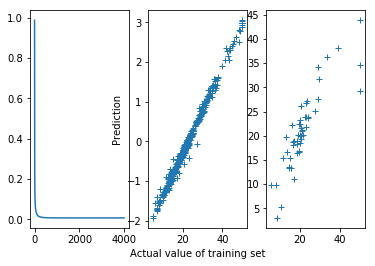

In [11]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from torch.utils.data import TensorDataset, DataLoader

import numpy  as np
import sklearn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

np.random.seed(0)
torch.manual_seed(0)

boston = load_boston()
X,y   = (boston.data, boston.target)
y      = y[:,None]
dim = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
num_train = X_train.shape[0]

x_mean = X_train.mean(axis = 0)
x_std     = X_train.std(axis = 0)
y_mean = y_train.mean()
y_std     = y_train.std()

X_train = (X_train - x_mean)    / x_std
X_test  = (X_test   - x_mean)    / x_std
y_train = (y_train  - y_mean)    / y_std

torch.set_default_dtype(torch.float64)
net = nn.Sequential(
    nn.Linear(dim, 50, bias = True), nn.ReLU(),
    nn.Linear(50,   50, bias = True), nn.ReLU(),
    nn.Linear(50,   50, bias = True), nn.ReLU(),
    nn.Linear(50,   1)
)

for l in net:
    if isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
        nn.init.zeros_(l.bias)

batch_size = 128
learning_rate = 1e-3
criterion = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = 0)

num_epochs = 4000
dataset = TensorDataset(torch.DoubleTensor(X_train).clone(), torch.DoubleTensor(y_train).clone())
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 125, gamma = 0.5)

rec = []
for i in range(num_epochs):
    scheduler.step()
    for x,y in loader:
        opt.zero_grad()
        loss = criterion(y, net(x))
        loss.backward()
        opt.step()
    full_loss = criterion(torch.DoubleTensor(y_train), net(torch.DoubleTensor(X_train)))
    rec.append(full_loss.item())
    if i > 0 and i % 10 == 0:
        print('Epoch %d, loss = %g' % (i, full_loss))


y_train = y_train * y_std + y_mean
py = net(torch.DoubleTensor(X_train)) * y_std + y_mean
err = y_train - py.detach().numpy()
mse = np.mean(err**2)
rmse = np.sqrt(mse) 
smse  = rmse / np.std(y_train)
print('rmse = %g, smse = %g' % (rmse, smse))
       
plt.subplot(131)
plt.plot(rec)
plt.subplot(132)
py = net(torch.DoubleTensor(X_train))
plt.plot(y_train, py.detach().numpy(), '+')
plt.xlabel('Actual value of training set')
plt.ylabel('Prediction')


py_test = net(torch.DoubleTensor(X_test))  * y_std + y_mean
mse_test = criterion(py_test, torch.DoubleTensor(y_test).reshape(py_test.shape))
rmse_test = torch.sqrt(mse_test)
print('rmse for test = %g' % rmse_test)
plt.subplot(133)
plt.plot(y_test, py_test.detach().numpy(),'+')

